## Version18 : Focal-CTC-Loss(0.25, 2) + lstm-dropout(0.1,0.1)  + LeakyReLU(0.05) + augement(Train) + Adam(0.001,1e-4) + Freeze(1~5) + cocotext

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import editdistance
import pickle
import time

from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, TensorBoard

from crnn_model_focal_ctc_loss import CRNN
from crnn_data_fcl_aug_merge import InputGenerator
from crnn_utils import decode
from utils.training import Logger, ModelSnapshot


Using TensorFlow backend.


In [2]:
from data_cracker import GTUtility

with open('gt_util_cocotext_train.pkl', 'rb') as f:
    gt_util_train = pickle.load(f)
    
with open('gt_util_cocotext_val.pkl', 'rb') as f:
    gt_util_val = pickle.load(f)

In [3]:
print(len(gt_util_train.image_names))
print(len(gt_util_val.image_names))

14708
3424


In [4]:
from crnn_utils import alphabet87
print(len(alphabet87))

87


In [5]:
input_width = 256
input_height = 32
batch_size = 128
input_shape = (input_width, input_height, 1)
max_string_len = 62

In [6]:
experiment = 'crnn_cocotext_v4'

## ---training---

In [7]:
alpha=0.25
gamma=1.5

model, model_pred = CRNN(input_shape, len(alphabet87), gru=False, alpha=alpha, gamma=gamma)

model.load_weights('checkpoints/201806162129_crnn_lstm_synthtext/weights.300000.h5')

max_string_len = 62

Instructions for updating:
Colocations handled automatically by placer.


/home/ina/anaconda3/envs/ina/lib/python3.7/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


In [8]:
freeze = ['conv1_1',
          'conv2_1',
          'conv3_1', 'conv3_2', 
          'conv4_1',
          'conv5_1',
          #'conv6_1',
          #'lstm1',
          #'lstm2'
         ]


In [9]:
gen_train = InputGenerator(gt_util_train, batch_size, alphabet87, input_shape[:2], 
                           grayscale=True, max_string_len=max_string_len)
gen_val = InputGenerator(gt_util_val, batch_size, alphabet87, input_shape[:2], 
                         grayscale=True, max_string_len=max_string_len, aug=False)

In [10]:
checkdir = './checkpoints/' + time.strftime('%Y%m%d%H%M') + '_' + experiment
if not os.path.exists(checkdir):
    os.makedirs(checkdir)

with open(checkdir+'/source.py','wb') as f:
    source = ''.join(['# In[%i]\n%s\n\n' % (i, In[i]) for i in range(len(In))])
    f.write(source.encode())
    
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=128, 
                                          write_graph=True, write_grads=False, write_images=False, 
                                          embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, 
                                          embeddings_data=None, update_freq='epoch')

# tensorboard --logdir=./logs

# livelossplot

from livelossplot.keras import PlotLossesCallback

#EarlyStopping
from keras.callbacks import EarlyStopping

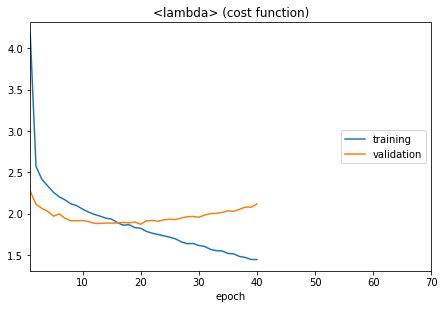

<lambda> (cost function):
training   (min:    1.444, max:    4.175, cur:    1.444)
validation (min:    1.870, max:    2.272, cur:    2.116)
Restoring model weights from the end of the best epoch
Epoch 00040: early stopping


In [11]:
#optimizer = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
optimizer = Adam(lr=0.0005, epsilon=0.001, decay=1e-5, clipnorm=1.)

for layer in model.layers:
    layer.trainable = not layer.name in freeze

# dummy loss, loss is computed in lambda layer
model.compile(loss={'focal_ctc_loss': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

#model.summary()

hist = model.fit_generator(generator=gen_train.generate(), # batch_size here?
                    steps_per_epoch=gt_util_train.num_objects // batch_size,
                    epochs=70
                           
                           
                           ,
                    validation_data=gen_val.generate(), # batch_size here?
                    validation_steps=gt_util_val.num_objects // batch_size,
                    callbacks=[
                        ModelCheckpoint(checkdir+'/weights.{epoch:03d}.h5', verbose=1, save_weights_only=True),
                        #ModelSnapshot(checkdir, 10000),
                        Logger(checkdir),
                        #tensorboard,
                        PlotLossesCallback(),
                        EarlyStopping(monitor='val_loss', mode='auto', restore_best_weights=True, verbose=1, patience=20)
                    ],
                    initial_epoch=0)



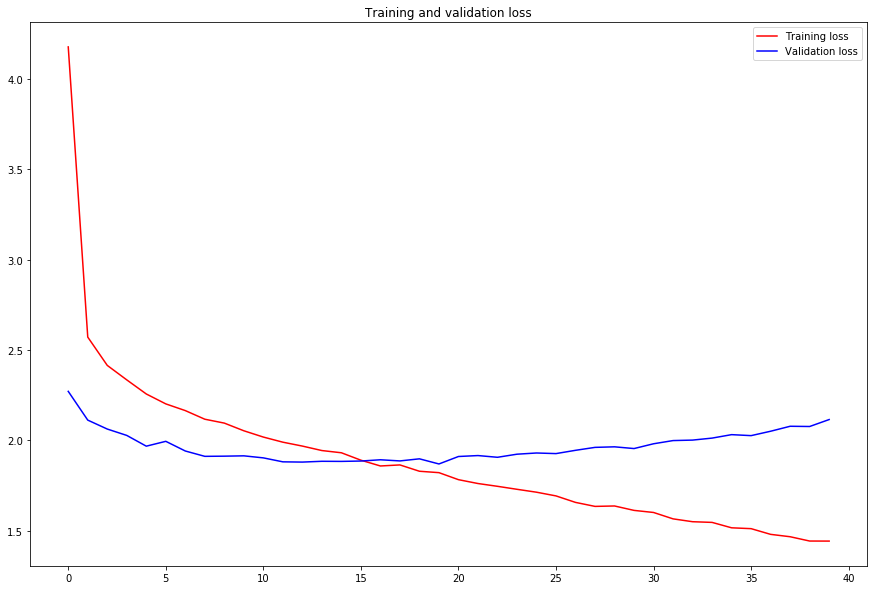

In [12]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(loss))
plt.figure(figsize=(15,10))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b',label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:
g = gen_val.generate()

NEW epoch



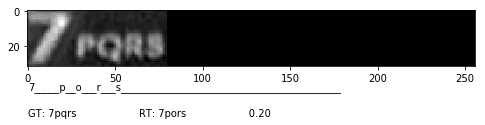

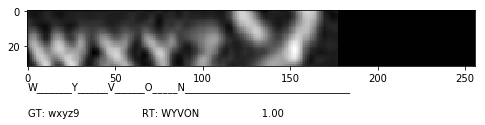

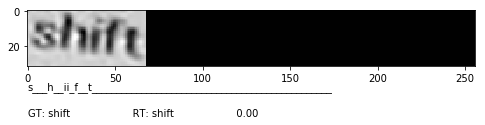

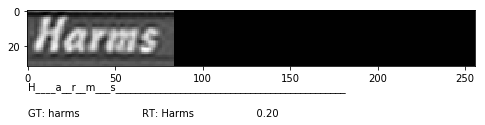

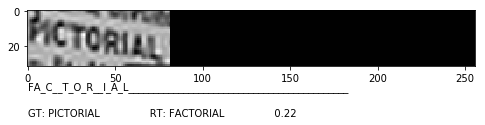

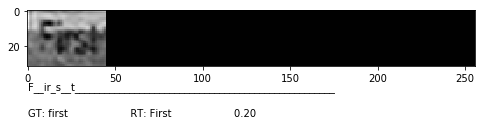

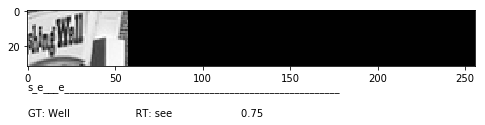

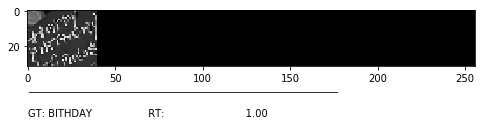

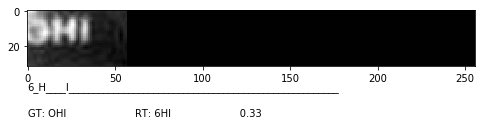

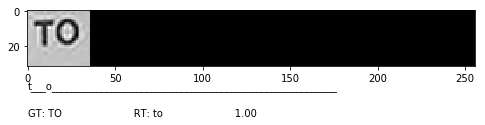

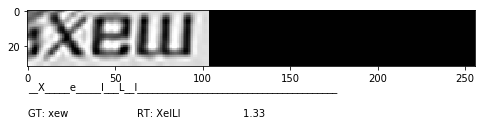

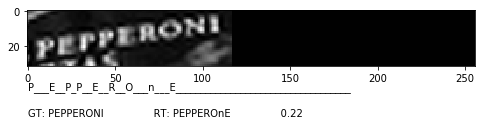

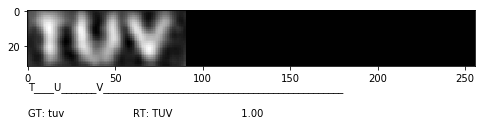

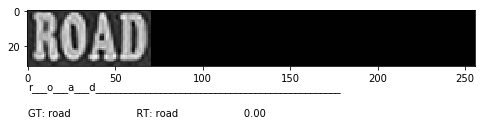

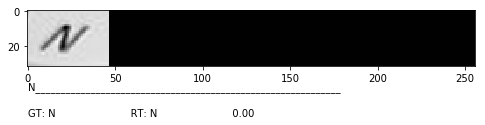

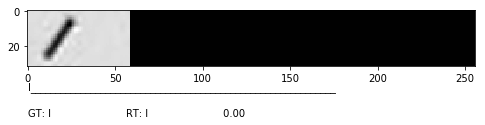

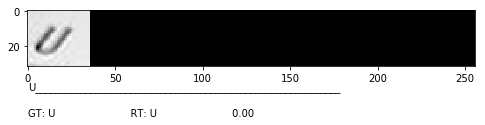

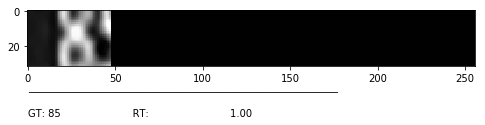

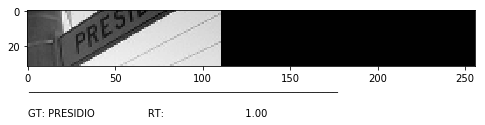

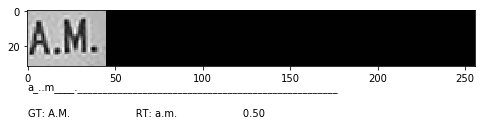

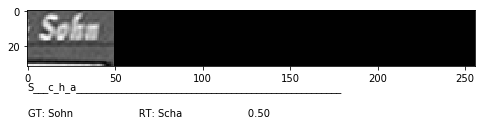

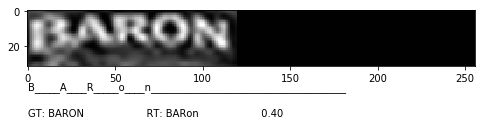

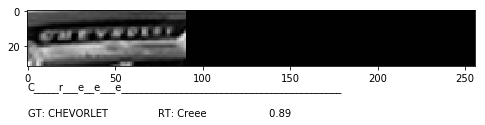

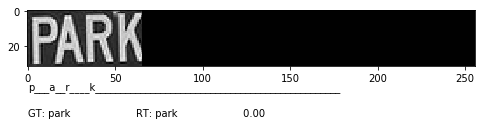

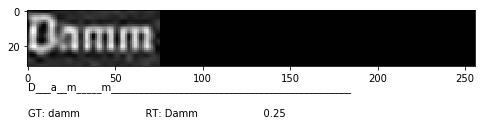

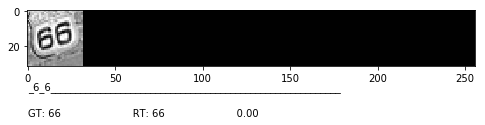

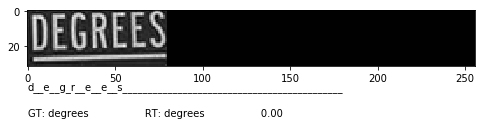

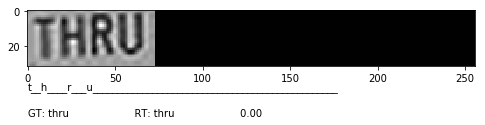

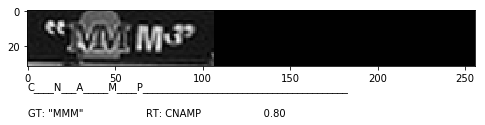

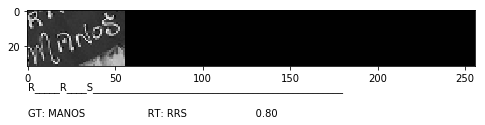

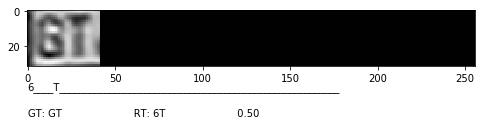

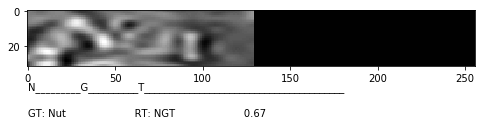

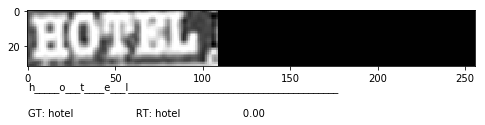

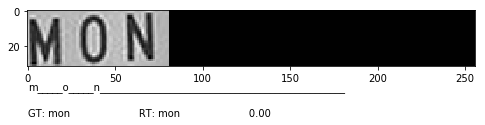

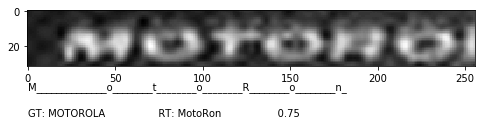

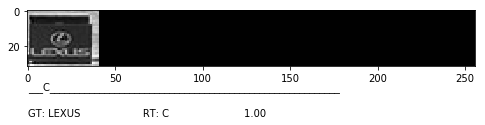

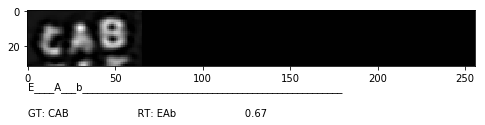

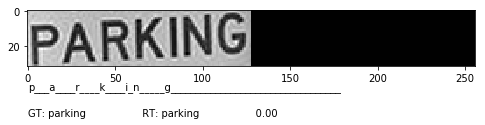

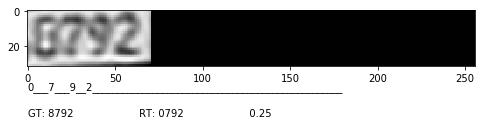

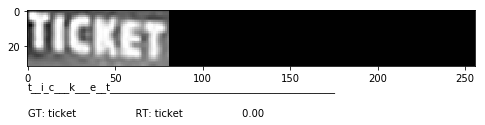

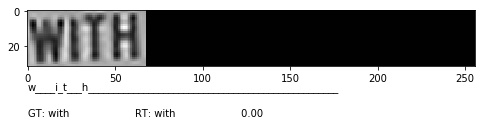

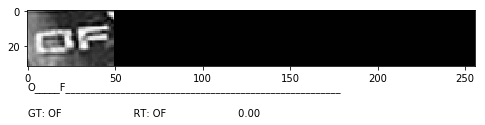

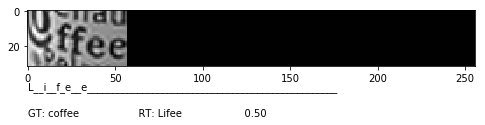

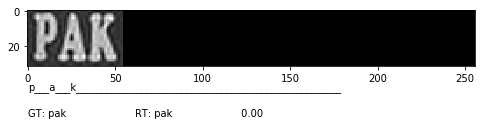

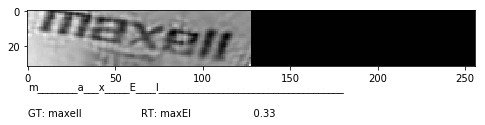

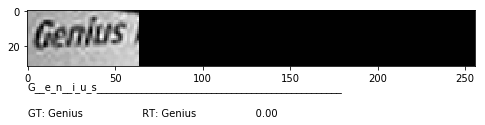

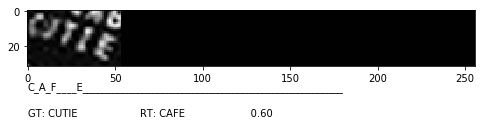

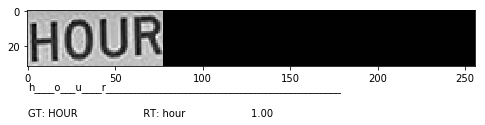

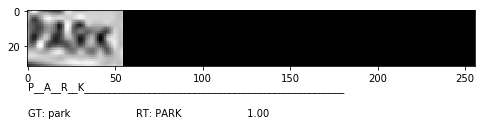

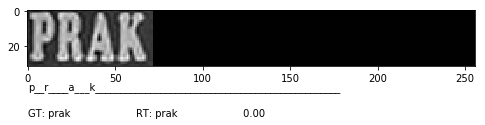

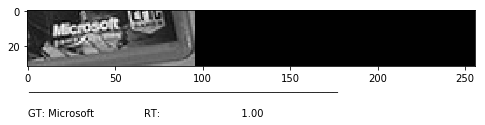

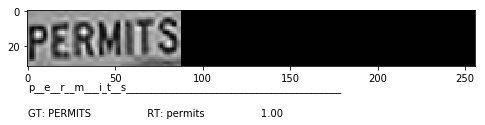

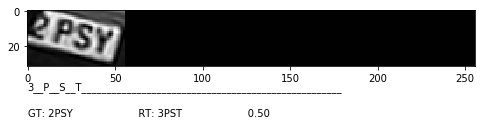

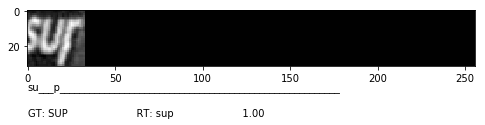

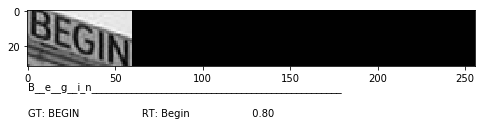

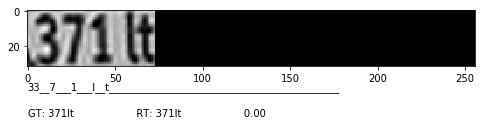

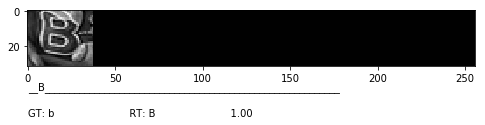

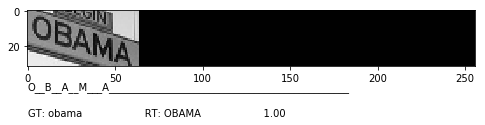

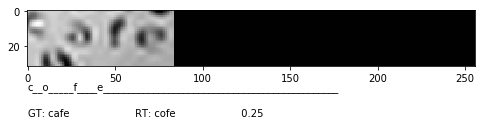

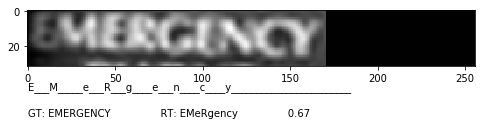

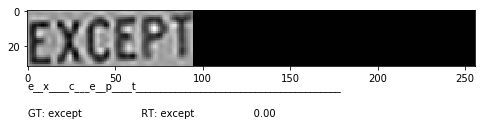

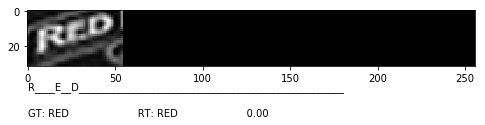

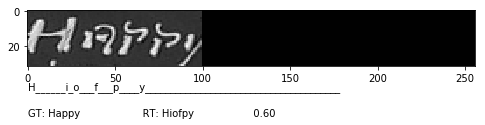

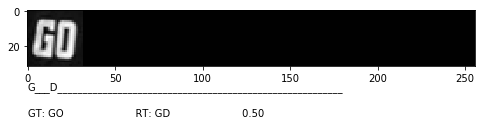

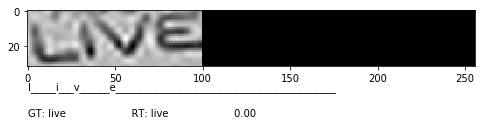

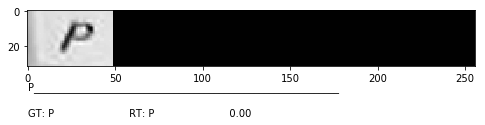

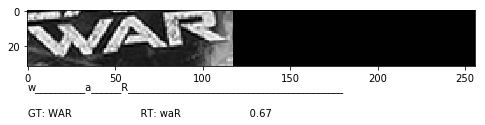

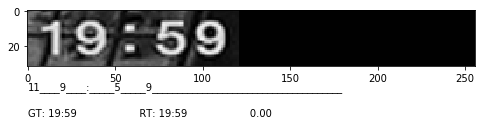

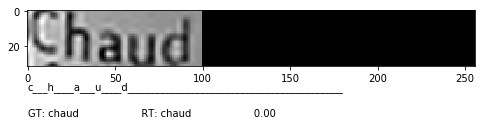

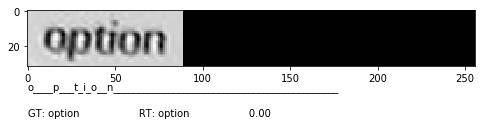

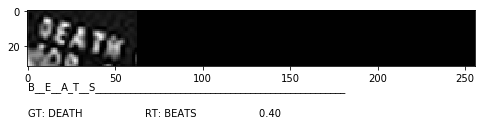

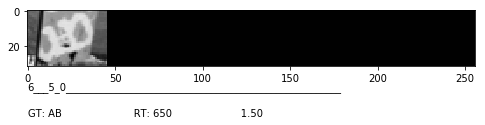

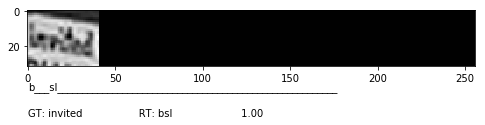

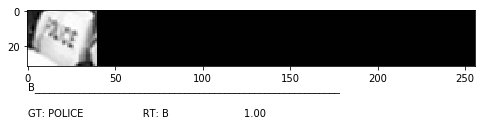

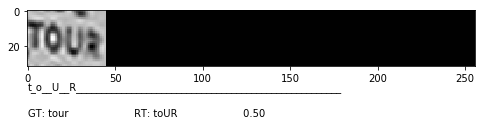

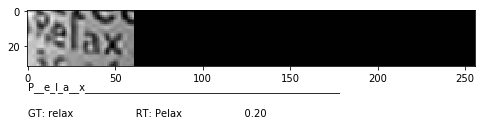

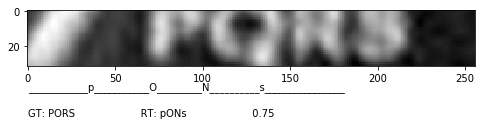

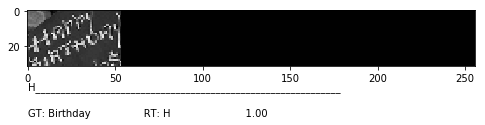

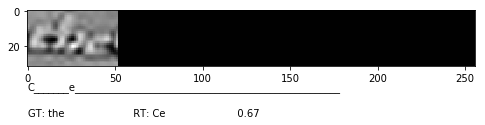

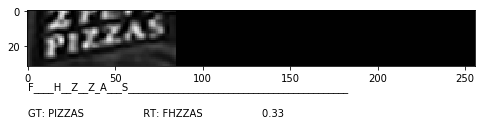

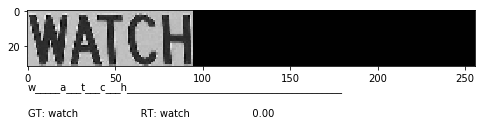

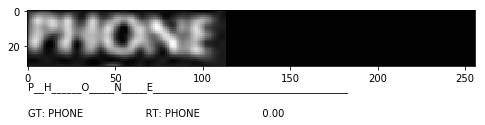

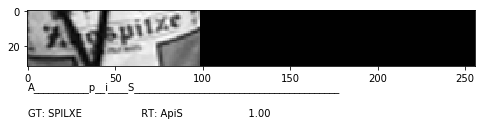

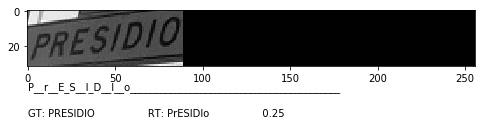

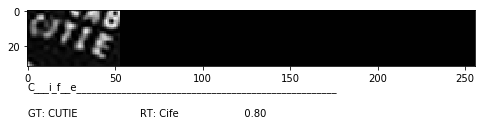

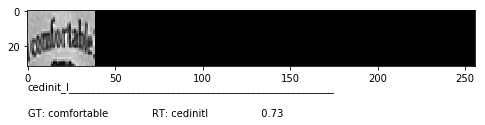

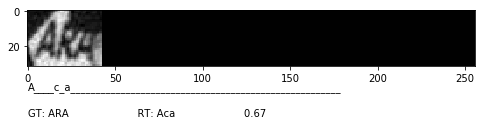

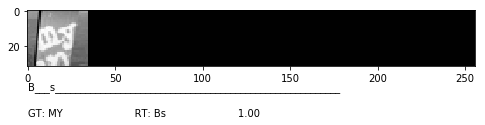

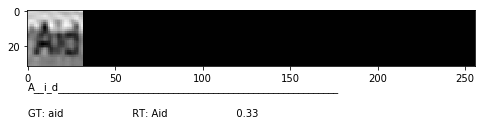

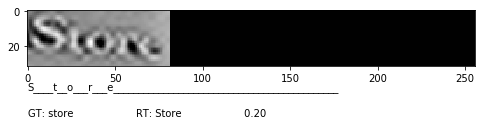

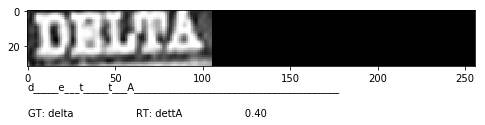

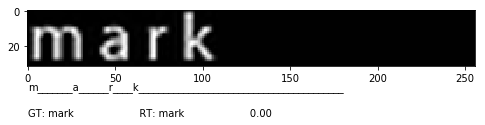

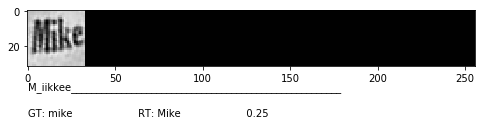

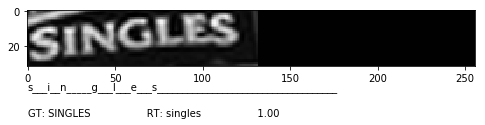

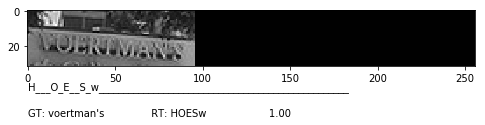

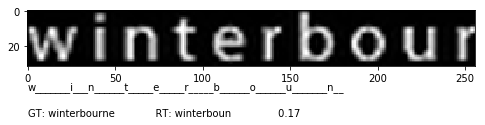

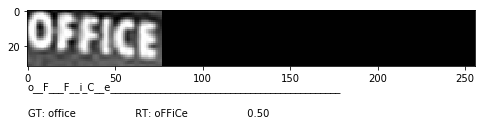

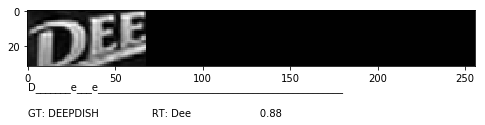

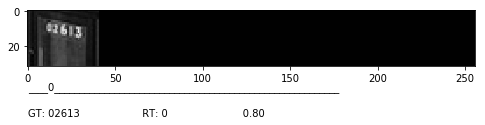

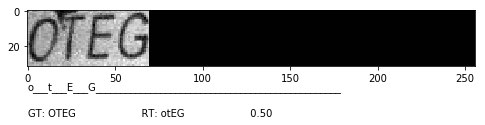

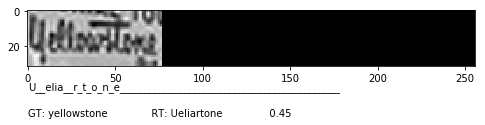

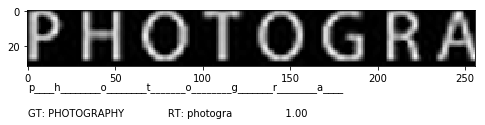

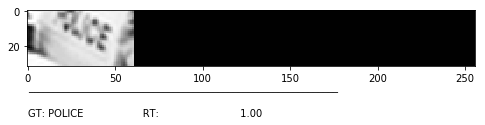

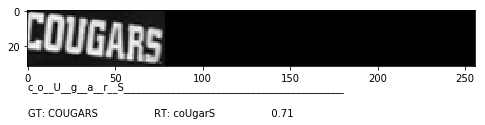

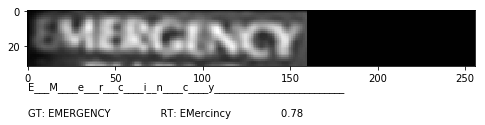

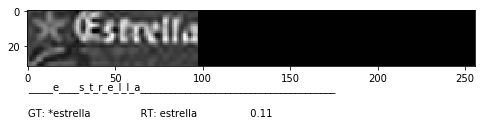

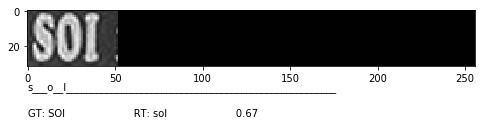

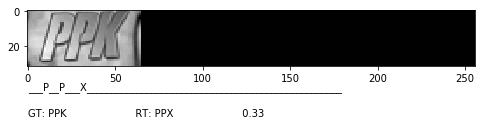

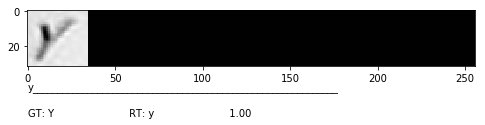

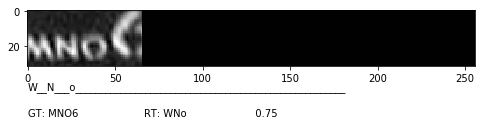

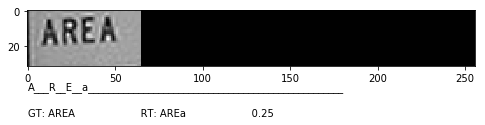

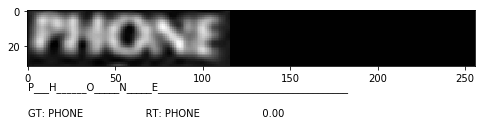

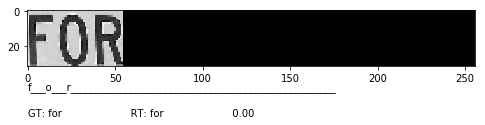

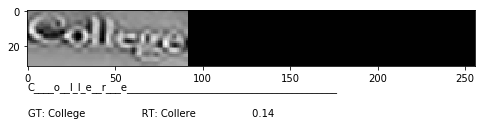

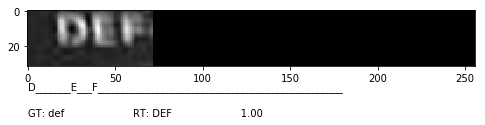

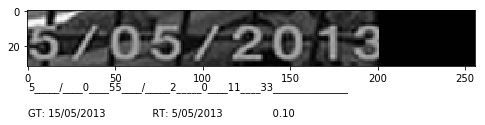

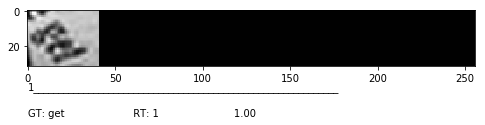

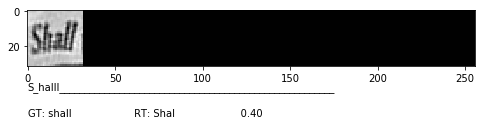

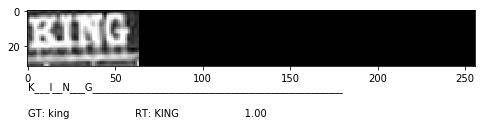

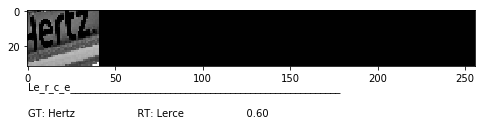

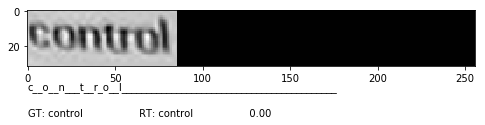

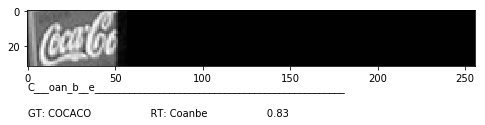

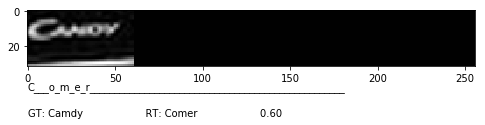

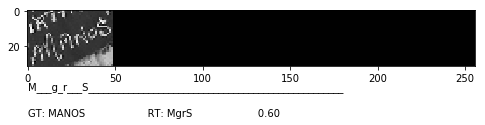

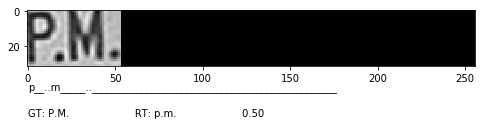

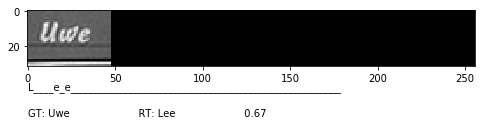

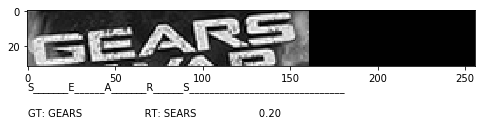

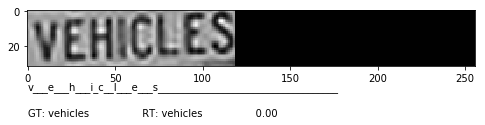


mean editdistance: 2.484
mean normalized editdistance: 0.487


In [14]:
d = next(g)

res = model_pred.predict(d[0]['image_input'])

mean_ed = 0
mean_ed_norm = 0

plot_name = 'crnn_cocotext'

for i in range(len(res)):
#for i in range(32):
    # best path, real ocr applications use beam search with dictionary and language model
    chars = [alphabet87[c] for c in np.argmax(res[i], axis=1)]
    gt_str = d[0]['source_str'][i]
    res_str = decode(chars)
    
    ed = editdistance.eval(gt_str, res_str)
    #ed = levenshtein(gt_str, res_str)
    ed_norm = ed / len(gt_str)
    mean_ed += ed
    mean_ed_norm += ed_norm
    
    # display image
    img = d[0]['image_input'][i][:,:,0].T
    plt.figure(figsize=[10,1.03])
    plt.imshow(img, cmap='gray', interpolation=None)
    ax = plt.gca()
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
    plt.text(0, 45, '%s' % (''.join(chars)) )
    plt.text(0, 60, 'GT: %-24s RT: %-24s %0.2f' % (gt_str, res_str, ed_norm))
    
    #file_name = 'plots/%s_recogniton_%03d.pgf' % (plot_name, i)
    file_name = 'plots/%s_recogniton_%03d.png' % (plot_name, i)
    #plt.savefig(file_name, bbox_inches='tight', dpi=300)
    #print(file_name)
    
    plt.show()
    
    #print('%-20s %-20s %s %0.2f' % (gt_str, res_str, ''.join(chars), ed_norm))

mean_ed /= len(res)
mean_ed_norm /= len(res)

print('\nmean editdistance: %0.3f\nmean normalized editdistance: %0.3f' % (mean_ed, mean_ed_norm))

# best_weight_is_20